# Self-organized criticality

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 7

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import itertools
import numpy as np
import matplotlib.pyplot as plt

import thinkplot

from matplotlib import rc
rc('animation', html='html5')

## Sand pile

In [2]:
from Sand import SandPile, SandPileViewer

In [3]:
pile = SandPile(3, 5)
n, m = pile.array.shape
pile.array = np.zeros((n, m), dtype=np.int32)
pile.array[n//2, m//2+1] = 5
pile.array[n//2, m//2-1] = 5
print(pile.array)

[[0 0 0 0 0]
 [0 5 0 5 0]
 [0 0 0 0 0]]


In [4]:
print(pile.step())
print(pile.array)

2
[[0 1 0 1 0]
 [1 1 2 1 1]
 [0 1 0 1 0]]


In [5]:
print(pile.total)

[[0 0 0 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]]


In [6]:
print(pile.sweep())
print(pile.array)

6
[[0 0 0 0 0]
 [0 1 2 1 0]
 [0 0 0 0 0]]


## Animation

In [7]:
pile = SandPile(20)
viewer = SandPileViewer(pile)

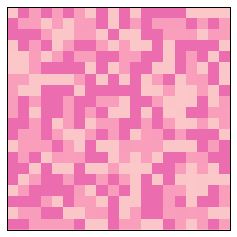

In [8]:
anim = viewer.animate(frames=100)

In [9]:
anim

In [ ]:
thinkplot.plot(pile.swept_seq[1:])

In [ ]:
thinkplot.plot(pile.toppled_seq)

In [ ]:
pile = SandPile(n=20)
viewer = SandPileViewer(pile)

thinkplot.preplot(cols=3)
viewer.step(100)
viewer.draw()

thinkplot.subplot(2)
viewer.step(100)
viewer.draw()

thinkplot.subplot(3)
viewer.step(100)
viewer.draw()

plt.savefig('chap08-1.pdf')

## Long tailed distributions

In [ ]:
n = 50
iters = 100000
pile = SandPile(n)
%time res = [pile.drop_and_run() for _ in range(iters)]

In [ ]:
duration, toppled = zip(*res)

In [ ]:
S = [s for s in toppled if s>0]

In [ ]:
T = [t for t in duration if t>0]

In [ ]:
from thinkstats2 import Hist, Cdf

hist = Hist(S)
thinkplot.Pdf(hist)
thinkplot.config(xlabel='Avalanche size',
                 ylabel='Number')

In [ ]:
x = 5700
thinkplot.plot([1, x], [x, 1], color='gray', linewidth=0.5)
thinkplot.Pdf(hist, linewidth=0.5)
thinkplot.config(xlabel='Avalanche size',
                 xlim=[1, 4000],
                 ylabel='PMF',
                 xscale='log',
                 yscale='log')

In [ ]:
x = 9000
hist = Hist(T)
thinkplot.plot([1, x], [x, 1], color='gray', linewidth=0.5)
thinkplot.Pdf(hist, linewidth=0.5)
thinkplot.config(xlabel='Avalanche duration',
                 xlim=[1, 1000],
                 ylabel='PMF',
                 xscale='log',
                 yscale='log')

## Fractal?

In [ ]:
def count_cells(a):
    n, m = a.shape
    n = int(min(n, m) / np.sqrt(2))
    
    res = []
    for i in range(10, n):
        top = (n-i) // 2
        left = (m-i) // 2
        box = a[top:top+i, left:left+i]
        total = np.sum(box)
        res.append((i, i**2, total))
        
    return res

In [ ]:
from scipy.stats import linregress

def test_fractal(a, ylabel=''):
    res = count_cells(a)
    steps, steps2, cells = zip(*res)

    thinkplot.plot(steps, steps2, label='d=2', linestyle='dashed')
    thinkplot.plot(steps, cells, label='sand pile')
    thinkplot.plot(steps, steps, label='d=1', linestyle='dashed')

    thinkplot.config(xscale='log', yscale='log',
                     xlabel='time steps', ylabel=ylabel,
                     xlim=[1, 600], loc='upper left')
    
    params = linregress(np.log(steps), np.log(cells))
    return params[0]

In [ ]:
n = 100
iters = 4000
pile = SandPile(n)
%time ks = [pile.drop_and_run() for _ in range(iters)]

In [ ]:
viewer = SandPileViewer(pile)
viewer.draw()

In [ ]:
test_fractal(pile.array==1)

In [ ]:
test_fractal(pile.array==2)

In [ ]:
test_fractal(pile.array==3)

## Single source sand pile

In [9]:
def tower(pile, factor=2):
    a = pile.array
    n, m = a.shape
    
    a[:, :] = 0
    a[n//2, m//2] = factor * n * m

In [10]:
def run_tower_pile(n, factor=2):
    pile = SandPile(n)
    tower(pile, factor)

    while True:
        k = pile.step()
        if k == 0:
            break
            
    viewer = SandPileViewer(pile)
    return pile, viewer

In [11]:
ss_pile = pile

CPU times: user 6.81 s, sys: 0 ns, total: 6.81 s
Wall time: 6.81 s


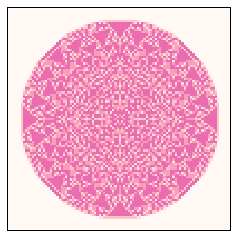

In [12]:
% time ss_pile, viewer = run_tower_pile(100, factor=2)
viewer.draw()

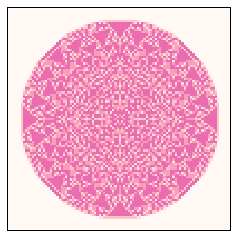

In [24]:
viewer.draw()

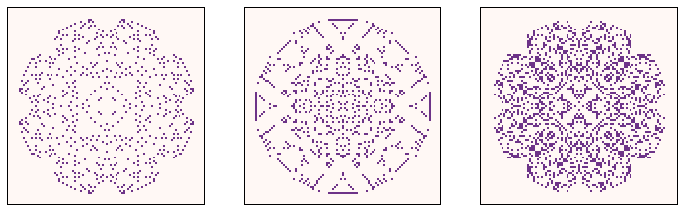

In [20]:
thinkplot.preplot(cols=3)
viewer.draw_array(ss_pile.array==1, vmax=1)

thinkplot.subplot(2)
viewer.draw_array(ss_pile.array==2, vmax=1)

thinkplot.subplot(3)
viewer.draw_array(ss_pile.array==3, vmax=1)

plt.savefig('chap08-2.pdf')

In [ ]:
test_fractal(ss_pile.array==1)

In [ ]:
test_fractal(ss_pile.array==2)

In [ ]:
test_fractal(ss_pile.array==3)

In [ ]:
def radial_box_count(a, plot=False):
    n, m = a.shape
    rows, cols = np.nonzero(a)
    indices = np.array([rows, cols])
    indices[0] -= n//2
    indices[1] -= m//2
    distances = np.sum(indices**2, axis=0)**0.5

    r = min(n, m) / 2.25
    xs = np.arange(10, r)
    ys = [np.sum(distances<=x) for x in xs ]
    d2 = [np.pi*x**2 for x in xs]
    
    if plot:
        thinkplot.plot(xs, d2, label='d=2')
        thinkplot.plot(xs, ys, label='sand pile')
        thinkplot.config(xlabel='distance', xscale='log',
                         ylabel='number of cells', yscale='log')
    
    params = linregress(np.log(xs), np.log(ys))
    return params[0]

In [ ]:
radial_box_count(ss_pile.array == 1)

In [ ]:
radial_box_count(ss_pile.array == 2)

In [ ]:
radial_box_count(ss_pile.array == 3)

In [ ]:
radial_box_count(ss_pile.array > 0)

In [ ]:
radial_box_count(pile.array == 1)

In [ ]:
radial_box_count(pile.array == 2)

In [ ]:
radial_box_count(pile.array == 3)

In [ ]:
radial_box_count(pile.array > 0)

## Spectral density

In [ ]:
from scipy.signal import welch
wave = pile.toppled_seq
nfft = 2048
fs, spectrum = welch(wave, fs=nfft, nfft=nfft)

In [ ]:
x = nfft
ys = np.array([x**1.63, 1]) / 4e3
thinkplot.plot([1, x], ys, color='gray', linewidth=0.5)

thinkplot.plot(fs, spectrum)
thinkplot.config(xlabel='frequency', xscale='log', xlim=[1, nfft],
                 ylabel='power', yscale='log', ylim=[1e-5, 5])

## On the other hand

In [ ]:
cdf = Cdf(ks)
thinkplot.Cdf(cdf)
thinkplot.config(xlabel='Avalanche size',
                 ylabel='Cdf',
                xscale='log')

In [ ]:
thinkplot.Cdf(cdf, complement=True)
thinkplot.config(xlabel='Avalanche size',
                 ylabel='Cdf',
                 xscale='log',
                 yscale='log')